In [1]:
import tensorflow as tf
from collections import Counter
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
import random

import tensorflow as tf
from keras import layers, models
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers.legacy import Adam
from keras.regularizers import l2

In [2]:
#traing data
real_images_path = 'ppg maps/PPG_maps_128x32_rvy/out_real_ryv'
fake_images_path = 'ppg maps/PPG_maps_128x32_rvy/out_fake_ryv'

images = []
labels = []

# Load real images
for filename in os.listdir(real_images_path)[:2433]:
    if filename.endswith(".png"):  
        img = cv2.imread(os.path.join(real_images_path, filename))
        img = img_to_array(img)
        images.append(img)
        labels.append(1)  

# Load fake images
for filename in os.listdir(fake_images_path)[:2413]:
    if filename.endswith(".png"):  
        img = cv2.imread(os.path.join(fake_images_path, filename))
        img = img_to_array(img)
        images.append(img)
        labels.append(0)  

train_images = np.array(images)
train_labels = np.array(labels)

temp = list(zip(train_images, train_labels))
random.shuffle(temp)
res1, res2 = zip(*temp)
res1, res2 = list(res1), list(res2)

X_train = np.array(res1) / 255.0
y_train= np.array(res2)

In [3]:
print(X_train.shape, y_train.shape)

(4846, 128, 32, 3) (4846,)


In [4]:
y_train[:20]

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [5]:
#testing
real_images_path = 'ppg maps/PPG_maps_128x32_rvy/out_real_ryv'
fake_images_path = 'ppg maps/PPG_maps_128x32_rvy/out_fake_ryv'

images = []
labels = []

# Load real images
for filename in os.listdir(real_images_path)[2433:]:
    if filename.endswith(".png"):  
        img = cv2.imread(os.path.join(real_images_path, filename))
        img = img_to_array(img)
        images.append(img)
        labels.append(1)  

# Load fake images
for filename in os.listdir(fake_images_path)[2413:]:
    if filename.endswith(".png"):  
        img = cv2.imread(os.path.join(fake_images_path, filename))
        img = img_to_array(img)
        images.append(img)
        labels.append(0)  

test_images = np.array(images)
test_labels = np.array(labels)

X_test= np.array(test_images)/255.0
y_test= test_labels

In [6]:
print(X_test.shape, y_test.shape)

(1981, 128, 32, 3) (1981,)


In [7]:
# Use the learning rate schedule in the optimizer
custom_optimizer = Adam(learning_rate=0.00005)

# Define the CNN model
model_dscnn = Sequential()

# Depth-wise separable convolution layer
model_dscnn.add(layers.DepthwiseConv2D(3, activation='relu', input_shape=(128,32, 3)))
model_dscnn.add(layers.BatchNormalization())
model_dscnn.add(layers.SeparableConv2D(32, (3, 3), activation='relu'))
model_dscnn.add(layers.MaxPooling2D((2, 2)))
model_dscnn.add(layers.BatchNormalization())

# Another depth-wise separable convolution layer
model_dscnn.add(layers.SeparableConv2D(64, (3, 3), activation='relu'))
model_dscnn.add(layers.MaxPooling2D((2, 2)))
model_dscnn.add(layers.BatchNormalization())
model_dscnn.add(layers.SeparableConv2D(64, (3, 3), activation='relu'))
model_dscnn.add(layers.MaxPooling2D((2, 2)))
model_dscnn.add(layers.BatchNormalization())

model_dscnn.add(Flatten())
model_dscnn.add(layers.Dense(128, activation='relu'))
model_dscnn.add(layers.Dropout(0.5))
model_dscnn.add(layers.Dense(1, activation='sigmoid'))  # 2 classes for binary classification

# Compile the model
model_dscnn.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_dscnn.summary()

2023-12-10 00:29:53.357984: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-12-10 00:29:53.358006: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-10 00:29:53.358011: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-10 00:29:53.358088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 00:29:53.358109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d (Depthwis  (None, 126, 30, 3)        30        
 eConv2D)                                                        
                                                                 
 batch_normalization (Batch  (None, 126, 30, 3)        12        
 Normalization)                                                  
                                                                 
 separable_conv2d (Separabl  (None, 124, 28, 32)       155       
 eConv2D)                                                        
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 14, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 62, 14, 32)        1

In [8]:
from keras.callbacks import EarlyStopping
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min')

history = model_dscnn.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[early_stop_callback], epochs=80, batch_size=32)

Epoch 1/80


2023-12-10 00:29:54.238787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


152/152 [==============================] - 4s 23ms/step - loss: 0.9831 - accuracy: 0.5487 - val_loss: 0.6930 - val_accuracy: 0.4967
Epoch 2/80
152/152 [==============================] - 3s 18ms/step - loss: 0.8530 - accuracy: 0.6024 - val_loss: 0.6891 - val_accuracy: 0.5068
Epoch 3/80
152/152 [==============================] - 3s 18ms/step - loss: 0.7993 - accuracy: 0.6265 - val_loss: 0.6533 - val_accuracy: 0.6355
Epoch 4/80
152/152 [==============================] - 3s 18ms/step - loss: 0.7621 - accuracy: 0.6506 - val_loss: 0.6066 - val_accuracy: 0.6779
Epoch 5/80
152/152 [==============================] - 3s 18ms/step - loss: 0.6826 - accuracy: 0.6760 - val_loss: 0.6031 - val_accuracy: 0.7052
Epoch 6/80
152/152 [==============================] - 3s 18ms/step - loss: 0.6680 - accuracy: 0.6830 - val_loss: 0.5869 - val_accuracy: 0.7224
Epoch 7/80
152/152 [==============================] - 3s 19ms/step - loss: 0.6365 - accuracy: 0.6998 - val_loss: 0.5652 - val_accuracy: 0.7360
Epoch 8/80

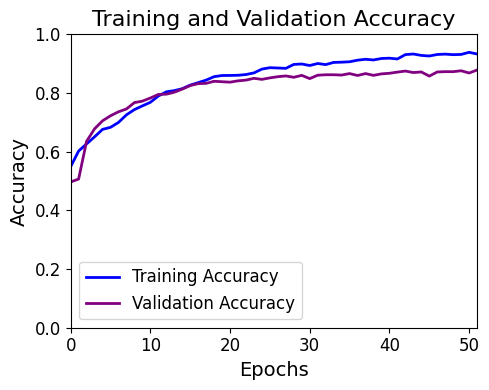

In [9]:
plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2, markersize=6)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='purple', linewidth=2, markersize=6)

# Customize the graph
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0, 1])
plt.xlim([0, len(history.history['accuracy']) - 1])

# Display the plot
plt.tight_layout()  # Adjusts plot parameters for better layout
plt.show()

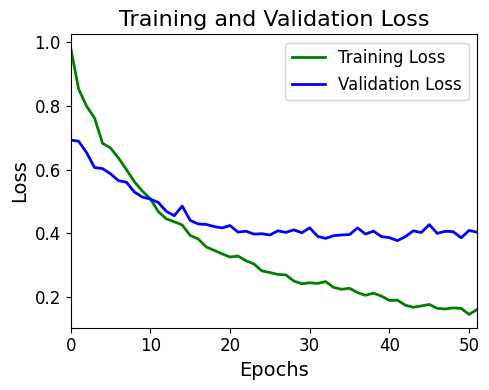

In [10]:
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Training Loss', color='green', linewidth=2, markersize=6)
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue', linewidth=2, markersize=6)

# Customize the graph
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim([0, 1])
plt.xlim([0, len(history.history['loss']) - 1])

# Display the plot
plt.tight_layout()  # Adjusts plot parameters for better layout
plt.show()

In [11]:
# Evaluate the model
loss, accuracy = model_dscnn.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

62/62 [==============================] - 0s 6ms/step - loss: 0.4034 - accuracy: 0.8783
Test loss: 0.4033973515033722
Test accuracy: 0.8783442974090576


In [12]:
model_dscnn.save('models/model.h5')

/Users/abhishekaggarwal/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
